In [2]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.


import requests
from urllib.parse import unquote
from tqdm import tqdm

# Chuỗi URL được mã hóa
encoded_url = 'https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240510%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240510T171529Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D348640283931f9c4dd02ba0bb5fd66196965d46418636da031b90b545926d07ce5879ed7be696c922ebb5a2b569a62d675549dff761f099a3e2ab79214260854c17c0f650418c8f00d42df510661af656cfd7f70852ee2c1f562763f38d1fa28686f310de50f43f9b123858b7928321fd6ed6185131e98f1949bf312e15b2c4af43abaf4c6deee5b11514e3e1d827d689e83ec88690ad80c61284691561f284f92a160cacc1fabe61159f873033aff1eb001fb5eeba273dcf05851585a4a50b10c27520a0d42b9a7eef9dbae5520f36493457590c3d489ed9b336bfe7fc49a211f3406d3808a2a5aa02de77094be743170f064fd5191a35e98f08ba5b43daccf'

# Giải mã URL
decoded_url = unquote(encoded_url)

# Tên tệp tải xuống
file_name = 'reviews.zip'

# Thực hiện tải xuống
response = requests.get(decoded_url, stream=True)
total_size = int(response.headers.get('content-length', 0))

with open(file_name, 'wb') as file:
    with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading", ascii=True) as pbar:
        for data in response.iter_content(chunk_size=4096):
            file.write(data)
            pbar.update(len(data))

print('Data source import complete')




/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Downloading: 100%|##########| 254M/254M [00:59<00:00, 4.30MB/s] 

Data source import complete


## Unzip 

In [4]:
zip_file_path="reviews.zip"
extract_dir_path="/Users/macbook/Desktop/Artificial Intelligence/Finally/input"
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_path)
    print("Extracting done")

Extracting done


## Introduction

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review.

The dataset contains the following columns:

1. productId: The product ID of the reviewed item.
2. userId: The user ID of the reviewer.
3. profileName: The name of the reviewer's profile.
4. helpfulness: The number of helpful votes the review received.
5. score: The rating of the product (1-5 stars).
6. time: The date and time of the review.
7. summary: A short summary of the review.
8. text: The full text of the review.

The dataset can be used for a variety of purposes, such as:
1. Sentiment analysis: To determine the overall sentiment of the reviews (positive, negative, or neutral).
2. Topic modeling: To identify the topics that are discussed in the reviews.
3. Product recommendation: To recommend products to users based on their reviews.
4. Spam detection: To identify and remove spam reviews.

The Amazon Fine Food Reviews dataset is a valuable resource for anyone interested in understanding consumer behavior and the online review process. It is a large and comprehensive dataset that can be used to answer a variety of research questions.

### ***Project Objective: Examining the outcomes of sentiment analysis in review polarity classification by employing K-nearest neighbors (KNN) across Bag of Words, TFIDF, and Word2Vector representations.***

#### ***Description:*** This project aims to analyze the sentiment of reviews by implementing a review polarity classification system. We will compare the performance of three different feature representations, namely Bag of Words, TFIDF, and Word2Vector. The evaluation will be conducted using the K-nearest neighbors (KNN) algorithm to determine the effectiveness of each representation in classifying review sentiments accurately.


#### ***Steps:***
1. Import necessary libraries
2. Data Cleaning and Storing the cleaned reviews in a new database
3. Convert reviews into vectors (Bag of Words, Tf-Idf, Word2Vec) and sentiment classification using KNN
4. Conclusion

## 1. Importing Libraries and Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from nltk.stem.porter import PorterStemmer
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm import tqdm
from sklearn.manifold import TSNE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [8]:
# opening a connection to database
con = sqlite3.connect('input/database.sqlite')

# querying database to get filtered data without 3 star review
# we are not considering the reviews with value of 3 as it is not a good indicator of polarity of review
data = pd.read_sql_query('SELECT * FROM Reviews WHERE Score !=3', con)
print(data.shape)
data.head(3)


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


We will use the score column provided to get the polarity of the review.
1. reviews with score 4 and 5 will be considered positive
2. reviews with score 1 and 2 will be considered negative
3. we have dropped the reviews with value of 3 as it is not a good indicator of polarity of review

In [9]:
# convert score values to sentiment
def score_to_sentiment(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'

data['Score'] = data['Score'].apply(score_to_sentiment)

## 2. Data Cleaning

Steps:
1. Sorting Data by ProductID
2. Deduplication
3. Helpfulness numerator should always be less than helpfulness denominator
4. Cleaning HTML Tags and Punctuation

In [10]:
# Sorting data acc to product ID
sorted_data = data.sort_values(by='ProductId', axis=0, ascending=True, kind='quicksort', na_position='last')

# Deduplication
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

# helpfulness numerator should always be less than helpfulness denominator
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('Shape of our data remaining:', final.shape)

# checking the percentage of data remaining
print('Percentage of Data Remaining:', (final.shape[0] / data.shape[0]) * 100)

Shape of our data remaining: (364171, 10)
Percentage of Data Remaining: 69.25852107399194


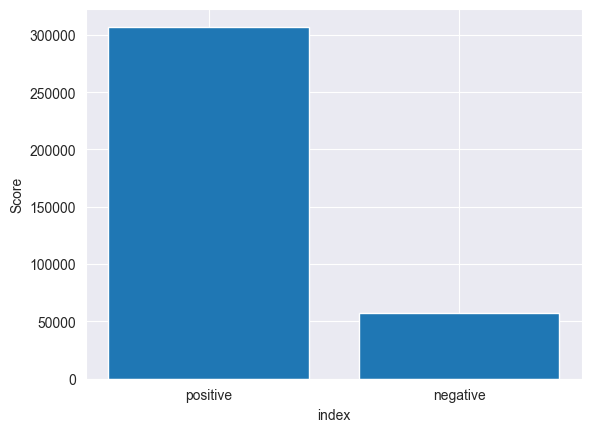

In [19]:
# let's check how positive and negative reviews are distributed
plt.bar(final['Score'].value_counts().index, final['Score'].value_counts().values)
plt.xlabel('index')
plt.ylabel('Score')
plt.show()


In [20]:
# find sentences containing HTML tags and punctuation
# we can see that there are a lot of unwanted elements in the raw text provided to us
# these elements will cause unnecessary dimensions in our vector conversions.
import re
i=0
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))) and (len(re.findall('[?|!|\'|"|#]', sent))):
        print('Index:', i)
        print(sent)
        break
    i += 1

Index: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [21]:
# source ->
# 1. https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
# 2. https://datagy.io/python-remove-punctuation-from-string/

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

# function to clean the word of any punctuation or special characters
# please note that you can add any missed character using | operator
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]',r'',sentence)
    return  cleaned

res = cleanhtml(final['Text'].values[6])
res = cleanpunc(res)
print(res)

I set aside at least an hour each day to read to my son 3 yo At this point I consider myself a connoisseur of childrens books and this is one of the best Santa Clause put this under the tree Since then weve read it perpetually and he loves it  First this book taught him the months of the year  Second its a pleasure to read Well suited to 15 yo old to 4+  Very few childrens books are worth owning Most should be borrowed from the library This book however deserves a permanent spot on your shelf Sendaks best


In [25]:
# làm sạch html, dấu câu, từ dừng và bắt nguồn từng từ trong mỗi bài đánh giá
# xin lưu ý rằng đối với Word2Vec, sẽ không bao gồm tất cả các bước này để xử lý trước.
# lưu trữ những đánh giá cuối cùng này trong cơ sở dữ liệu Final.sqlite

if not os.path.isfile('final.sqlite'):
    cleaned_reviews=[]
    cleaned_reviews_w2v = []
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        filtered_sentence_w2v = []
        sent = cleanhtml(sent)
        for word in sent.split():
            for cleaned_words in cleanpunc(word).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    filtered_sentence_w2v.append(cleaned_words.lower())
                    if(cleaned_words.lower() not in stop):
                        stem_word=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stem_word)
        filtered_sentence = b' '.join(filtered_sentence)
        filtered_sentence_w2v = ' '.join(filtered_sentence_w2v)
        cleaned_reviews.append(filtered_sentence)
        cleaned_reviews_w2v.append(filtered_sentence_w2v)
    final['CleanedText']=cleaned_reviews
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    final['CleanedText_w2v'] = cleaned_reviews_w2v

    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    print('Done..!!')

else:
    print('File already Exist')

File already Exist


In [26]:
# creating a function to visualize tsne results

def tsne_visualizer(data, label, title):
    # TSNE
    from sklearn.manifold import TSNE

    tsne_model = TSNE(n_components=2, n_iter=2000)
    tsne_data = tsne_model.fit_transform(data)

    tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, label)).T, columns=['1st_component', '2nd_component', 'label'])
    tsne_df

    sns.scatterplot(data=tsne_df, x='1st_component', y='2nd_component', hue='label')
    plt.title(title)
    plt.show()

# tsne_visualizer(data=bow_standerdised_data, label=df_final['Score'].values)

## 3. Chuyển đổi đánh giá thành vectơ và phân loại cảm xúc bằng KNN

### ***Mục tiêu:*** Chuyển đổi từng đánh giá hoặc câu thành một vectơ và sử dụng K Nearest Neighbor để phân loại.

Trong phần này, chúng tôi sẽ chuyển đổi các đánh giá đã được làm sạch của mình thành vectơ bằng cách sử dụng ***Bag Of Words, TF-IDF, Average Word2Vec và TF-IDF Weighted*** Word2Vec để chúng tôi có thể biểu diễn chúng trong mặt phẳng n chiều và sau đó sử dụng Knearest Hàng xóm để phân loại các đánh giá tích cực và tiêu cực.


Dưới đây là các bước chúng tôi sẽ thực hiện cho từng kỹ thuật vector hóa:
1. Vector hóa: BOW, TF-IDF, Avg Word2Vec, Word2Vec có trọng số TF-IDF
2. Lấy mẫu quá mức: Lấy mẫu ngẫu nhiên
3. Tiêu chuẩn hóa
4. Giảm kích thước: PCA ; (sẽ bị bỏ qua đối với Word2Vec)
5. K-NN và Báo cáo phân loạiv

In [27]:
# đọc các dữ liệu đã làm sạch trong final

if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
    conn.close()
else:
    print("File Not Available in the location")

## (A) Bag Of Words

### Phân chia dựa trên thời gian
Phân tách dựa trên thời gian đề cập đến việc thực hành phân chia dữ liệu hoặc mẫu dựa trên tiêu chí thời gian. Mục tiêu chính của việc phân tách dựa trên thời gian là đảm bảo rằng thứ tự thời gian của dữ liệu được giữ nguyên trong quá trình phân tách. Bằng cách sử dụng tính năng phân tách dựa trên thời gian, các mô hình học máy có thể được đào tạo và đánh giá dựa trên dữ liệu gần giống với kịch bản trong thế giới thực mà chúng sẽ được triển khai. Cách tiếp cận này giúp nắm bắt các mô hình thời gian và sự phụ thuộc, đồng thời cung cấp ước tính đáng tin cậy về hiệu suất của mô hình trong các ứng dụng thực tế.

Các bước:
1. Sắp xếp dữ liệu theo thời gian
2. Tách dữ liệu đã sắp xếp của tôi thành dữ liệu huấn luyện, dữ liệu xác thực và dữ liệu kiểm tra. sẽ lấy 70% dữ liệu đầu tiên để đào tạo và xác thực, phần còn lại để kiểm tra.

hình dạng của tập dữ liệu cuối cùng : (7000, 13)
	Dữ liệu Train
Hình dạng của dữ liệu: (3920, 13)
Phân phối lớp:
Score
positive    3491
negative     429
Name: count, dtype: int64
	Dữ liệu Cross Validation
Hình dạng của dữ liệu: (980, 13)
Phân phối lớp:
Score
positive    839
negative    141
Name: count, dtype: int64
	Dữ liệu Test 
Hình dạng của dữ liệu: (2100, 13)
Phân phối lớp:
Score
positive    1860
negative     240
Name: count, dtype: int64


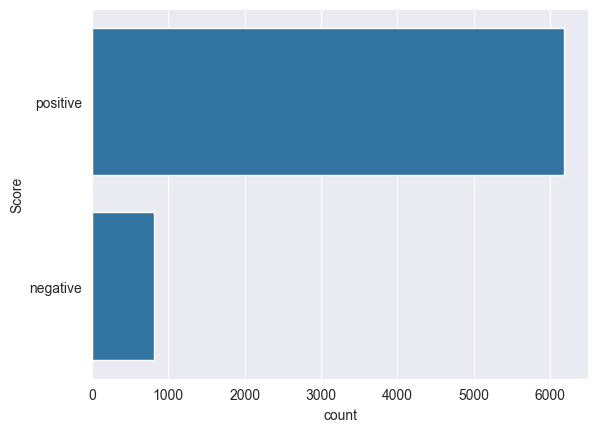

In [37]:
# sắp xếp dữ liệu theo thời gian vì nó là một biểu diễn tốt hơn của trường hợp sử dụng thực tế

# hãy thao tác trên 7000 điểm dữ liệu vì hạn chế bộ nhớ
df_final = final.sort_values(by='Time')[:7000]
print('hình dạng của tập dữ liệu cuối cùng :', df_final.shape)
print("="*20)

# lấy 70 phần trăm dữ liệu của chúng tôi cho train và 30 phần trăm cho test
# của 70 phần trăm dữ liệu, chúng tôi sẽ sử dụng 80 phần trăm cho train và 20 phần trăm cho cross validation
n_train = int(np.ceil(df_final.shape[0] * 0.70))
n_cv = int(n_train * 0.80)

df_train = df_final[:n_cv]
df_cv = df_final[n_cv:n_train]
df_test = df_final[n_train:]

# kiểm tra phân phối lớp của mỗi phần dữ liệu
df_lst = [('\tDữ liệu Train', df_train), ('\tDữ liệu Cross Validation', df_cv), ('\tDữ liệu Test ', df_test)]
for df_name, df in df_lst:
    print(df_name)
    print('Hình dạng của dữ liệu:', df.shape)
    print('Phân phối lớp:')
    print(df['Score'].value_counts())
    print('='*20)

#vẽ biểu đồ số lượng điểm dữ liệu trong mỗi lớp
sns.countplot(df_final['Score'])
plt.show()


### Vectorization using Bag Of Words

In [38]:
# Bag of Words
vectorizer_bow = CountVectorizer()
train_bow = vectorizer_bow.fit_transform(df_train['CleanedText'].values)
cv_bow = vectorizer_bow.transform(df_cv['CleanedText'].values)
test_bow = vectorizer_bow.transform(df_test['CleanedText'].values)

print(train_bow.shape)
print(cv_bow.shape)
print(test_bow.shape)

(3920, 11312)
(980, 11312)
(2100, 11312)


### Oversampling
Các bộ dữ liệu không cân bằng, trong đó các lớp không được thể hiện như nhau, có thể đặt ra những thách thức trong các nhiệm vụ học máy. Chúng tôi có số lượng đánh giá tiêu cực thấp đáng kể so với đánh giá tích cực và chúng tôi sẽ sử dụng Lấy mẫu ngẫu nhiên để giải quyết vấn đề này.

RandomOverSampler: RandomOverSampler hoạt động bằng cách sao chép ngẫu nhiên các ví dụ từ lớp thiểu số cho đến khi nó đạt kích thước tương tự như lớp đa số. Kỹ thuật lấy mẫu tổng hợp này giúp giảm thiểu vấn đề mất cân bằng lớp, cho phép mô hình học hỏi từ cách biểu diễn dữ liệu cân bằng hơn.

Hình dạng của dữ liệu trước khi oversampling: (3920, 11312) 




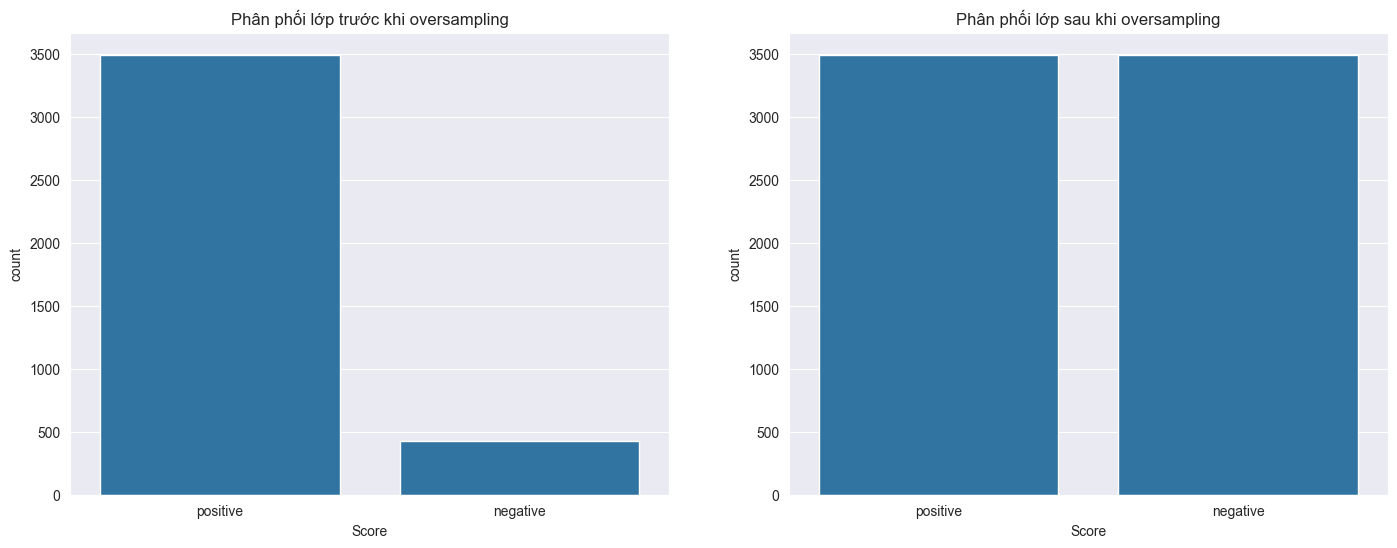

Hình dạng của dữ liệu sau khi oversampling: (6982, 11312)


In [39]:
# vẽ biểu đồ mất cân bằng lớp trước khi thực hiện oversampling
plt.figure(1, figsize=(17,6))  # Tạo một hình vẽ mới với kích thước 17x6
plt.subplot(1,2,1)  # Tạo một subplot với 1 hàng, 2 cột, và sử dụng ô thứ nhất
sns.countplot(x=df_train['Score'])  # Vẽ biểu đồ đếm số lượng mẫu trong mỗi lớp của dữ liệu huấn luyện trước khi thực hiện oversampling
plt.title('Phân phối lớp trước khi oversampling')  #
print('Hình dạng của dữ liệu trước khi oversampling:', train_bow.shape, '\n\n') 

# thực hiện oversampling bằng cách sử dụng SMOTE
# oversampling dữ liệu huấn luyện của chúng tôi
ros = RandomOverSampler()  # Khởi tạo một instance của RandomOverSampler
X_train_bow, Y_train_bow = ros.fit_resample(train_bow,df_train['Score'])  # Thực hiện oversampling dữ liệu huấn luyện bằng phương pháp Random Over-Sampling (ROS)

# vẽ biểu đồ phân phối lớp sau khi oversampling
plt.subplot(1,2,2)  # Chuyển sang ô subplot thứ hai
sns.countplot(x=Y_train_bow)  # Vẽ biểu đồ đếm số lượng mẫu trong mỗi lớp sau khi thực hiện oversampling
plt.title('Phân phối lớp sau khi oversampling')  
plt.show()  
print('Hình dạng của dữ liệu sau khi oversampling:', X_train_bow.shape)  # In ra hình dạng của dữ liệu sau khi thực hiện oversampling


### Standardization (Tiêu chuẩn hoá)

In [40]:
# standardization
scaler_bow = StandardScaler()
X_train_bow_standardised = scaler_bow.fit_transform(X_train_bow.toarray())
X_cv_bow_standardised = scaler_bow.transform(cv_bow.toarray())
X_test_bow_standardised = scaler_bow.transform(test_bow.toarray())


### Dimensionality Reduction( Giảm kích thước)
Giảm kích thước là một kỹ thuật cơ bản trong học máy nhằm mục đích giải quyết vấn đề về kích thước bằng cách giảm số lượng tính năng hoặc biến trong tập dữ liệu. Các bộ dữ liệu chiều cao có thể đưa ra những thách thức như tăng độ phức tạp tính toán, trang bị quá mức và khó khăn trong việc diễn giải và trực quan hóa dữ liệu. Các phương pháp giảm kích thước giúp giảm thiểu những vấn đề này bằng cách trích xuất các tính năng có nhiều thông tin nhất hoặc tạo ra các biểu diễn dữ liệu mới, có chiều thấp hơn.
Quá trình vector hóa BOW của chúng tôi đã tạo ra khoảng 11K kích thước cho mỗi vectơ của chúng tôi, chúng tôi sẽ sử dụng PCA để giải quyết vấn đề này.

3000
Số chiều cần thiết để giải thích 95% tổng phương sai: 2258
Phương sai được giải thích: 0.9500495820576075


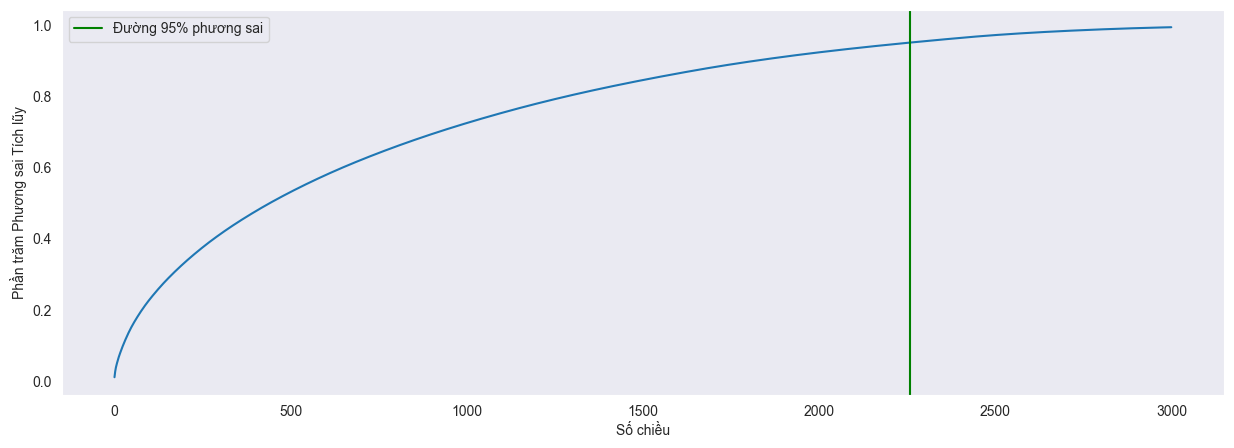

In [42]:
# Giảm chiều dữ liệu sử dụng phương pháp PCA hoặc Truncated SVD

# Sử dụng PCA với số thành phần chính (components) là 3000
pca = PCA(n_components=3000)
pca.fit(X_train_bow_standardised)  # Huấn luyện PCA trên dữ liệu huấn luyện đã chuẩn hóa
explained_variance = pca.explained_variance_ratio_  # Lấy tỷ lệ phương sai được giải thích bởi mỗi thành phần chính
print(len(explained_variance))  # In ra số lượng tỷ lệ phương sai được giải thích

# Xác định số chiều cần thiết để giải thích 95% tổng phương sai
dim_req_var = sum(np.cumsum(explained_variance) <= 0.95)
print('Số chiều cần thiết để giải thích 95% tổng phương sai:', dim_req_var)
print('Phương sai được giải thích:', np.cumsum(explained_variance)[dim_req_var])

# Vẽ biểu đồ hiển thị phương sai tích lũy theo số chiều
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(list(range(len(explained_variance))), np.cumsum(explained_variance))
plt.axvline(x=dim_req_var, color='g', label='Đường 95% phương sai')
plt.xlabel('Số chiều')
plt.ylabel('Phần trăm Phương sai Tích lũy')
plt.legend()
plt.show()

# Sử dụng PCA để giảm chiều dữ liệu cho dữ liệu huấn luyện, dữ liệu cross validation và dữ liệu kiểm tra
X_train_bow_pca = pca.transform(X_train_bow_standardised)[:, :dim_req_var]
X_cv_bow_pca = pca.transform(X_cv_bow_standardised)[:, :dim_req_var]
X_test_bow_pca = pca.transform(X_test_bow_standardised)[:, :dim_req_var]

# Xác định nhãn cho dữ liệu huấn luyện, dữ liệu cross validation và dữ liệu kiểm tra
y_train = Y_train_bow
y_cv = df_cv['Score'].values
y_test = df_test['Score'].values


### K-Nearest Neighbors

K-Nearest Neighbors (KNN) là một thuật toán phổ biến và trực quan được sử dụng cho cả nhiệm vụ phân loại và hồi quy trong học máy. Đây là một thuật toán phi tham số, nghĩa là nó không đưa ra các giả định về phân bổ dữ liệu cơ bản. KNN đưa ra dự đoán dựa trên sự tương đồng giữa các phiên bản trong không gian đặc trưng. Chúng tôi sẽ sử dụng khoảng cách Euclide làm thước đo khoảng cách cho trường hợp sử dụng này.

1. Thuật toán K-Nearest Neighbors (KNN) sẽ được thực thi với một phạm vi k giá trị, cụ thể từ 1 đến 29 với kích thước bước là 2, đảm bảo chỉ xem xét các giá trị lẻ.
2. Sau đó, mô hình KNN sẽ được huấn luyện bằng cách sử dụng dữ liệu huấn luyện và dữ liệu xác thực sẽ được sử dụng để đánh giá độ chính xác, điểm f1 (dương) và điểm f1 (âm) cho mỗi giá trị của k.
3. Giá trị k liên quan đến độ chính xác cao nhất sẽ được chọn và k tối ưu này sẽ được sử dụng để tạo ra số liệu độ chính xác cuối cùng. Ngoài ra, một báo cáo phân loại toàn diện và ma trận nhầm lẫn sẽ được tạo bằng dữ liệu thử nghiệm.

100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Độ chính xác tối đa là 0.8367346938775511 với giá trị K là 1
F1 score tối đa trên dữ liệu CV cho nhãn positive là 0.9102132435465768 với giá trị K là 1
F1 score tối đa trên dữ liệu CV cho nhãn negative là 0.1945288753799392 với giá trị K là 9

Confusion matrix:
               pred_positive  pred_negative
true_positive           1781             79
true_negative            219             21

Classification Report:
              precision    recall  f1-score   support

    negative       0.21      0.09      0.12       240
    positive       0.89      0.96      0.92      1860

    accuracy                           0.86      2100
   macro avg       0.55      0.52      0.52      2100
weighted avg       0.81      0.86      0.83      2100


Accuracy on Test Data: 0.8580952380952381


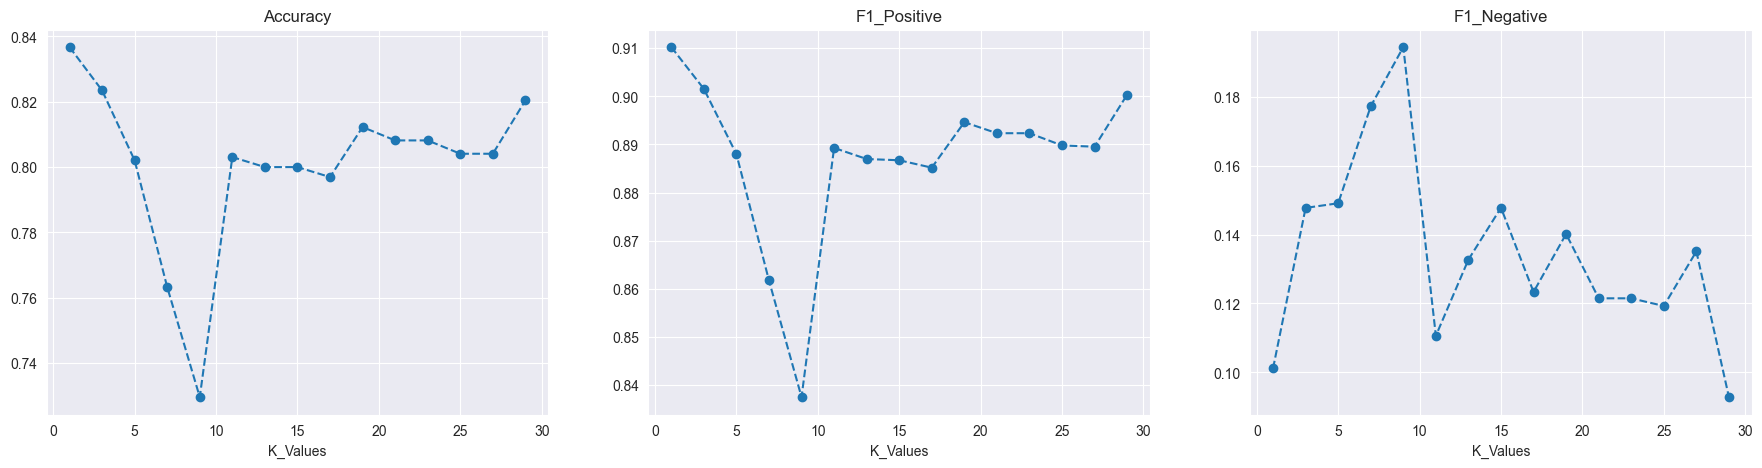

In [43]:
# Sử dụng KNN để phân loại dữ liệu
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1,30,2))

# Vòng lặp qua các giá trị K để tìm ra giá trị tốt nhất
for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_bow_pca, y_train)
    pred = knn.predict(X_cv_bow_pca)
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    accuracy.append(accuracy_score(y_cv, pred))

positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))

# In ra kết quả tốt nhất đạt được
print('Độ chính xác tối đa là {a} với giá trị K là {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('F1 score tối đa trên dữ liệu CV cho nhãn positive là {a} với giá trị K là {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('F1 score tối đa trên dữ liệu CV cho nhãn negative là {a} với giá trị K là {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# Vẽ biểu đồ hiển thị accuracy, F1-score cho các giá trị K
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# Huấn luyện mô hình KNN trên dữ liệu kiểm tra và tạo các ma trận liên quan
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_bow_pca, y_train)
pred = knn.predict(X_test_bow_pca)

# Tạo confusion matrix và báo cáo phân loại để đánh giá hiệu suất
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

#Precision là tỷ lệ giữa số lượng dự đoán chính xác của một lớp và tổng số dự đoán của lớp đó
#Recall là tỷ lệ giữa số lượng dự đoán chính xác của một lớp và tổng số điểm thực sự thuộc lớp đó trong dữ liệu.
#F1-score là một trung bình điều hòa giữa precision và recall. 
# Trong trường hợp này, precision và recall cho nhãn negative khá thấp, chỉ khoảng 21% và 9% tương ứng.

### ***Bow Result:***
mô hình phân loại đã đạt được độ chính xác 86% trên tập dữ liệu, cho thấy rằng nó đã phân loại chính xác 86% trường hợp, mặc dù độ chính xác cho thấy mô hình đã hoạt động tốt, hãy xem xét sự sai lệch.

Khi xem xét ma trận nhầm lẫn, chúng tôi nhận thấy rằng trong số các trường hợp dương tính thực tế, mô hình đã dự đoán chính xác 1.787 là dương tính (dương tính thật), nhưng lại phân loại sai 75 là âm tính (âm tính giả). Ngoài ra, trong số các trường hợp âm tính thực tế, mô hình đã dự đoán chính xác 26 là âm tính (âm tính thật), trong khi phân loại sai 214 là dương tính (dương tính giả).

Độ chính xác của lớp dương tính là 89%, cho thấy rằng trong số tất cả các trường hợp được dự đoán là dương tính thì 89% thực sự là dương tính. Tỷ lệ thu hồi đối với lớp tích cực là 96%, cho thấy mô hình đã xác định chính xác 96% trường hợp tích cực. Điểm f1 cho lớp tích cực là 93%, kết hợp độ chính xác và khả năng thu hồi thành một số liệu duy nhất và điều này cho thấy rằng mô hình dự đoán lớp tích cực thực sự tốt.

Mặt khác, độ chính xác của lớp âm tương đối thấp ở mức 28%, ngụ ý rằng chỉ 28% trường hợp được dự đoán là âm là thực sự âm. Tỷ lệ thu hồi đối với lớp phủ định là 12%, cho thấy mô hình đã gặp khó khăn trong việc xác định chính xác các trường hợp phủ định. Điểm f1 cho lớp phủ định là 17%. Điều này cho thấy rằng mô hình của chúng tôi rất kém trong việc dự đoán loại hoặc đánh giá tiêu cực.

Để chẩn đoán sự cố, chúng tôi có thể sử dụng nhiều kỹ thuật khác nhau nhưng hãy trực quan hóa dữ liệu đào tạo của chúng tôi ở dạng 2D để hiểu rõ hơn mức độ phân tách giữa các đánh giá tích cực và tiêu cực.

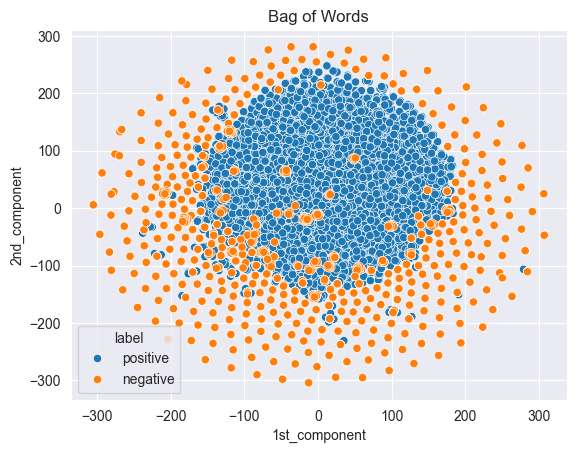

In [44]:
# visualizing BOW with TSNE

title = 'Bag of Words'
tsne_visualizer(data=X_train_bow_pca, label=y_train, title=title)

## (B) TF-IDF

In [45]:
# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
train_tfidf = vectorizer_tfidf.fit_transform(df_train['CleanedText'].values)
cv_tfidf = vectorizer_tfidf.transform(df_cv['CleanedText'].values)
test_tfidf = vectorizer_tfidf.transform(df_test['CleanedText'].values)

print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(3920, 11312)
(980, 11312)
(2100, 11312)


Shape of data before oversampling: (3920, 11312) 




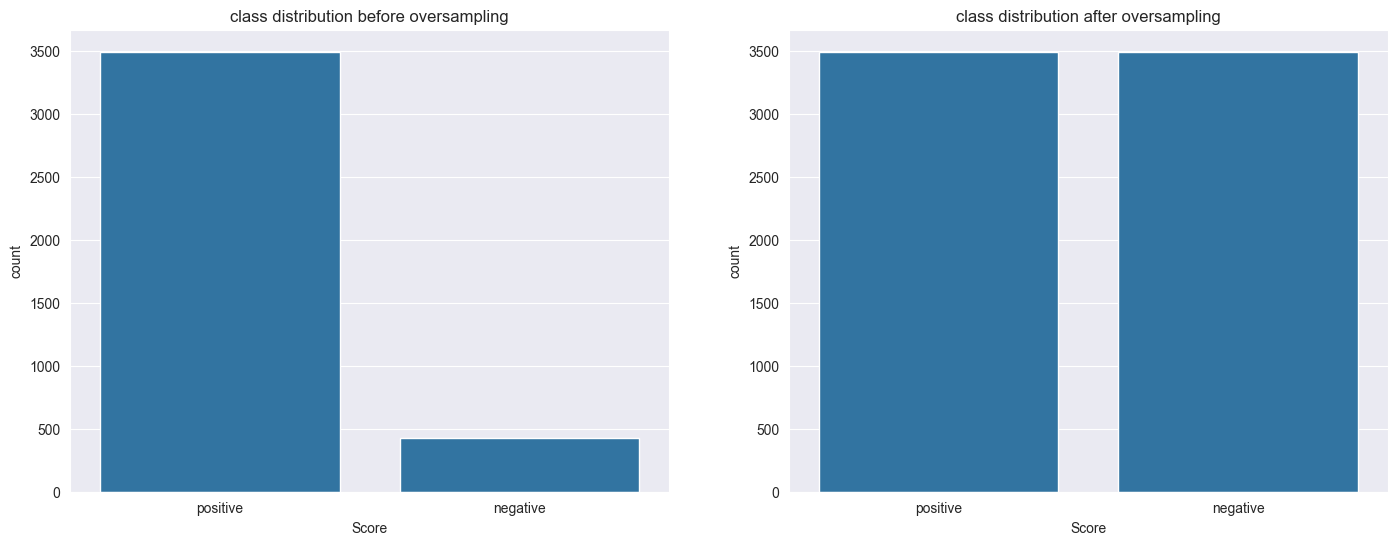

Shape of data after oversampling: (6982, 11312)


In [46]:
## OVERSAMPLING

# plotting class imbalance before oversampling
plt.figure(1, figsize=(17,6))
plt.subplot(1,2,1)
sns.countplot(x=df_train['Score'])
plt.title('class distribution before oversampling')
print('Shape of data before oversampling:', train_tfidf.shape, '\n\n')

# performing oversampling using smote
# oversampling our train data
ros = RandomOverSampler()
X_train_tfidf, Y_train_tfidf = ros.fit_resample(train_tfidf,df_train['Score'])

# plotting class dist after oversampling
plt.subplot(1,2,2)
sns.countplot(x=Y_train_tfidf)
plt.title('class distribution after oversampling')
plt.show()
print('Shape of data after oversampling:', X_train_tfidf.shape)


In [47]:
# standardization
scaler_tfidf = StandardScaler()
X_train_tfidf_standardised = scaler_tfidf.fit_transform(X_train_tfidf.toarray())
X_cv_tfidf_standardised = scaler_tfidf.transform(cv_tfidf.toarray())
X_test_tfidf_standardised = scaler_tfidf.transform(test_tfidf.toarray())

3000
Dimensions required for 95 percent explained variance: 2612
Variance Explained: 0.9500274511553485


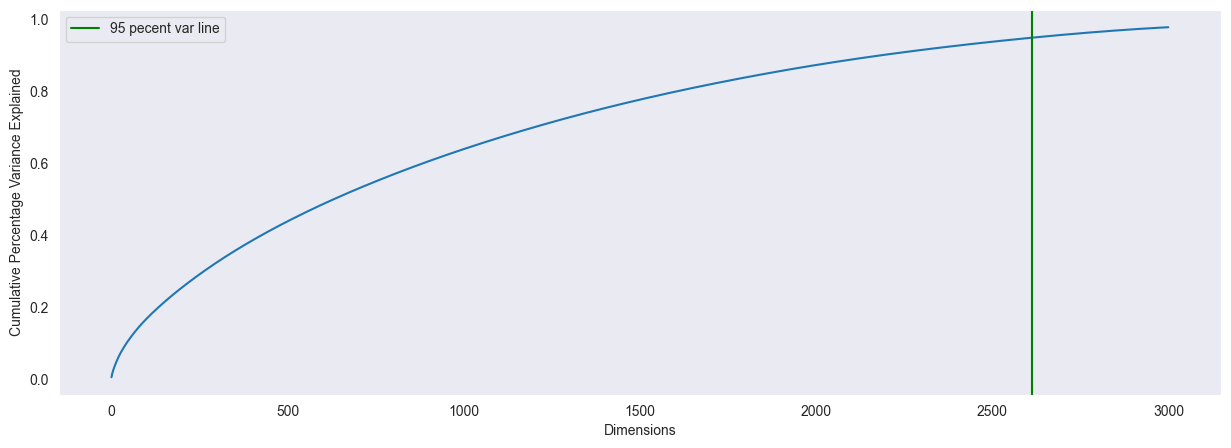

In [48]:
# dim reduction using PCA. We can also use truncated SVD

pca = PCA(n_components=3000)
pca.fit(X_train_tfidf_standardised)
explained_variance = pca.explained_variance_ratio_
print(len(explained_variance))


dim_req_var = sum(np.cumsum(explained_variance) <=0.95)
print('Dimensions required for 95 percent explained variance:', dim_req_var)
print('Variance Explained:', np.cumsum(explained_variance)[dim_req_var])

plt.figure(figsize=(15,5))
plt.grid()
plt.plot(list(range(len(explained_variance))),np.cumsum(explained_variance))
plt.axvline(x = dim_req_var, color = 'g', label='95 pecent var line')
plt.xlabel('Dimensions')
plt.ylabel('Cumulative Percentage Variance Explained')
plt.legend()
plt.show()


X_train_tfidf_pca = pca.transform(X_train_tfidf_standardised)[:, :dim_req_var]
X_cv_tfidf_pca = pca.transform(X_cv_tfidf_standardised)[:, :dim_req_var]
X_test_tfidf_pca = pca.transform(X_test_tfidf_standardised)[:, :dim_req_var]

y_train = Y_train_tfidf
y_cv = df_cv['Score'].values
y_test = df_test['Score'].values

In [ ]:
# Using KNN for classification
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1,30,2))

for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf_pca, y_train)
    pred = knn.predict(X_cv_tfidf_pca)
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    accuracy.append(accuracy_score(y_cv, pred))

positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))
print('The maximum accuracy is {a} with K value of {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('The maximum F1 score on CV data for positive labels is {a} with K value of {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('The maximum F1 score on CV data for negative labels is {a} with K value of {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# plotting accuracy f1-positive and f1-negative for K values
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# knn on our test data for reporting
# plase note that we can fit it on best value of our negativef1 score as well
# in order to boost the precision and recall for our negative reviews
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_tfidf_pca, y_train)
pred = knn.predict(X_test_tfidf_pca)

# generating relevant martices
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

### ***TFIDF Results:***
The classification model achieved an accuracy of 88.0% on the test data, indicating that it correctly classified 88.0% of the instances.

Examining the confusion matrix, we observe that out of the actual positive instances, the model correctly predicted 1,835 as positive (true positive), but it misclassified 25 instances as negative (false negative). Similarly, for the actual negative instances, the model correctly predicted 4 as negative (true negative), but it misclassified 236 instances as positive (false positive).

The precision for the positive class is 89%, suggesting that out of all instances predicted as positive, 89% were actually positive. The recall for the positive class is 99%, indicating that the model correctly identified 99% of the positive instances. The f1-score for the positive class is 93%, which combines precision and recall into a single metric.

On the other hand, the precision for the negative class is really low at 14%, implying that only 14% of the instances predicted as negative were truly negative. The recall for the negative class is 2%, indicating that the model struggled to correctly identify the negative instances. The f1-score for the negative class is 3%. Overall this model is basically acting as a dumb model classifying about each point as positive and is acting worse than BOW model.

We can use other measure like F1-Score for negative class to determin the best K in order to boost the prediction of negative class.

To diagnose the problem we can employ a variety of techniques but let's visualize our train data in 2D to better understand how well seperated the positive and negative reviews are.

In [ ]:
# visualizing TFIDF train data with TSNE

title = 'TF-IDF'
tsne_visualizer(data=X_train_tfidf_pca, label=y_train, title=title)

## Text to Vector Conversion With Word2Vec
***Word2Vec:*** Word2Vec is a widely used algorithm in natural language processing (NLP) that learns word embeddings, which are dense numerical representations of words. It is based on the idea that words with similar meanings often appear in similar contexts. Word2Vec captures these relationships by learning to predict a word based on its neighboring words or predicting neighboring words based on a given word. There are two ways we will be using Word2Vec to convert our sentence

1. ***Average Word2Vec:*** In the case of Average Word2Vec, the goal is to create a fixed-length vector representation for a document by averaging the word vectors of all the words in the document.

2. ***TF-IDF Weighted Word2Vec:*** TF-IDF weighted Word2Vec combines the concepts of TF-IDF and Word2Vec to create word embeddings that capture both the semantic meaning of words and their importance within a document corpus. It enhances the traditional Word2Vec model by incorporating the term frequency-inverse document frequency (TF-IDF) weighting scheme.

## (C) Average Word2Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
# we have already cleaned our reviews for Word2Vec
# now generate the data-structure suitable for the input of Word2Vec model
# required data structure => [[this], [is], [a], [review]]

def datastructure_generator_w2v(df):
    list_of_reviews = []
    for sent in tqdm(df['CleanedText_w2v'].values):
        list_of_reviews.append(sent.split())
    return list_of_reviews

In [ ]:
# constructing required structures

list_of_sent =  datastructure_generator_w2v(final)
list_of_sent_train =  datastructure_generator_w2v(df_train)
list_of_sent_cv = datastructure_generator_w2v(df_cv)
list_of_sent_test = datastructure_generator_w2v(df_test)
avg_w2v_data_dict = {'train':list_of_sent_train, 'cv':list_of_sent_cv, 'test':list_of_sent_test}

list_of_sent_idf_train = df_train['CleanedText_w2v']
list_of_sent_idf_cv = df_cv['CleanedText_w2v']
list_of_sent_idf_test = df_test['CleanedText_w2v']

print('Done..!!')

In [ ]:
# training Word2Vec model on our data
# this may take time to execute

model_w2v=Word2Vec(list_of_sent,min_count=5,vector_size=50, workers=2)

In [ ]:
# construct avg w2v

vocabulary_w2v = model_w2v.wv.key_to_index.keys()
avg_w2v_data_dict_final = {'train':None, 'cv':None, 'test':None}

for key,item in avg_w2v_data_dict.items():
    print(key)
    review_vectors_w2v = []

    for sentence in tqdm(item):
        word_count = 0
        sent_vec = np.zeros(shape=50)
        for word in sentence:
            if word in vocabulary_w2v:
                sent_vec += model_w2v.wv[word]
                word_count += 1

        if word_count != 0:
            sent_vec = sent_vec/word_count
        review_vectors_w2v.append(sent_vec)
    review_vectors_w2v = np.array(review_vectors_w2v)
    print(review_vectors_w2v.shape)
    avg_w2v_data_dict_final[key] = review_vectors_w2v

In [ ]:
# sanity check
for key,item in avg_w2v_data_dict_final.items():
    print(key)
    print(item.shape)

In [ ]:
# creating reference for ease of access
avg_w2v_data_train = avg_w2v_data_dict_final['train']
avg_w2v_data_cv = avg_w2v_data_dict_final['cv']
avg_w2v_data_test = avg_w2v_data_dict_final['test']

In [ ]:
## OVERSAMPLING

# plotting class imbalance before oversampling
plt.figure(1, figsize=(17,6))
plt.subplot(1,2,1)
plt.title('class distribution before oversampling')
sns.countplot(x=df_train['Score'])
print('Shape of data before oversampling:', avg_w2v_data_train.shape, '\n\n')

# performing oversampling using smote
# oversampling our train data
ros = RandomOverSampler()
avg_w2v_data_train, Y_avg_w2v_data_train = ros.fit_resample(avg_w2v_data_train,df_train['Score'])

# plotting class dist after oversampling
plt.subplot(1,2,2)
plt.title('class distribution after oversampling')
sns.countplot(x=Y_avg_w2v_data_train)
plt.show()
print('Shape of data after oversampling:', avg_w2v_data_train.shape)


In [ ]:
# standardization
scaler_avg_w2v = StandardScaler()
X_train_avg_w2v_standardised = scaler_avg_w2v.fit_transform(avg_w2v_data_train)
X_cv_avg_w2v_standardised = scaler_avg_w2v.transform(avg_w2v_data_cv)
X_test_avg_w2v_standardised = scaler_avg_w2v.transform(avg_w2v_data_test)

y_train = Y_avg_w2v_data_train
y_cv = df_cv['Score'].values
y_test = df_test['Score'].values

In [ ]:
# Using KNN for classification
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1,30,2))

for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_avg_w2v_standardised, y_train)
    pred = knn.predict(X_cv_avg_w2v_standardised)
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    accuracy.append(accuracy_score(y_cv, pred))

positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))
print('The maximum accuracy is {a} with K value of {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('The maximum F1 score on CV data for positive labels is {a} with K value of {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('The maximum F1 score on CV data for negative labels is {a} with K value of {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# plotting accuracy f1-positive and f1-negative for K values
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# knn on our test data for reporting
# plase note that we can fit it on best value of our negativef1 score as well
# in order to boost the precision and recall for our negative reviews
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_avg_w2v_standardised, y_train)
pred = knn.predict(X_test_avg_w2v_standardised)

# generating relevant martices
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

### ***Average Word2Vector Results:***

The classification model achieved an accuracy of 88% on the test data, indicating that it correctly classified 88% of the instances.

Analyzing the confusion matrix, we observe that out of the actual positive instances, the model correctly predicted 1,762 as positive (true positive), but it misclassified 98 instances as negative (false negative). Similarly, for the actual negative instances, the model correctly predicted 78 as negative (true negative), while misclassifying 162 instances as positive (false positive).

The precision for the positive class is 92%, suggesting that out of all instances predicted as positive, 92% were actually positive. The recall for the positive class is 95%, indicating that the model accurately identified 95% of the positive instances. The f1-score for the positive class is 93%, which combines precision and recall into a single metric.

On the other hand, the precision for the negative class is 44%, implying that only 44% of the instances predicted as negative were truly negative. The recall for the negative class is 33%, indicating that the model struggled to correctly identify the negative instances. The f1-score for the negative class is 38%.

Overall this model performs better than our previous models. We can see that the reviews are better seperated in the visualization below as well.

In [ ]:
# visualizing average word2vec with TSNE

title = 'Average Word2Vec'
tsne_visualizer(data=X_train_avg_w2v_standardised, label=y_train, title=title)

## TF-IDF Weighted Word2Vec

In [ ]:
# generating tfidf values
vectorizer_tfidf_w2v = TfidfVectorizer()
tfidf_data_w2v_train = vectorizer_tfidf_w2v.fit_transform(list_of_sent_idf_train)
tfidf_data_w2v_cv = vectorizer_tfidf_w2v.transform(list_of_sent_idf_cv)
tfidf_data_w2v_test = vectorizer_tfidf_w2v.transform(list_of_sent_idf_test)

tfidf_values_dict = {'train':tfidf_data_w2v_train, 'cv':tfidf_data_w2v_cv, 'test':tfidf_data_w2v_test}

In [ ]:
# constructing tf-idf weighted Word2Vec

tfidf_feature_names = list(vectorizer_tfidf_w2v.get_feature_names_out())
tfidf_w2v_data_dict_final = {'train':None, 'cv':None, 'test':None}

for key,item in avg_w2v_data_dict.items():
    print(key)
    w2v_tfidf_data = []

    for i,sentence in enumerate(tqdm(item)):
        tfidf_weight = 0
        sent_vec = np.zeros(shape=50)
        for word in sentence:
            try:
                tfidf_value = tfidf_values_dict[key][i,tfidf_feature_names.index(word)]
                # print(tfidf_value)
                w2v_vector = model_w2v.wv[word]
                sent_vec += tfidf_value * w2v_vector
                tfidf_weight += tfidf_value
            except:
                pass

        sent_vec = sent_vec / tfidf_weight
        w2v_tfidf_data.append(sent_vec)
    w2v_tfidf_data = np.array(w2v_tfidf_data)
    print(w2v_tfidf_data.shape)
    tfidf_w2v_data_dict_final[key] = w2v_tfidf_data

In [ ]:
# sanity check
for key,item in tfidf_w2v_data_dict_final.items():
    print(key)
    print(item.shape)

In [ ]:
tfidf_w2v_data_train = tfidf_w2v_data_dict_final['train']
tfidf_w2v_data_cv = tfidf_w2v_data_dict_final['cv']
tfidf_w2v_data_test = tfidf_w2v_data_dict_final['test']

In [ ]:
# dropping any NA values if present
tfidf_w2v_data_test

In [ ]:
## OVERSAMPLING

# plotting class imbalance before oversampling
plt.figure(1, figsize=(17,6))
plt.subplot(1,2,1)
plt.title('class distribution before oversampling')
sns.countplot(x=df_train['Score'])
print('Shape of data before oversampling:', tfidf_w2v_data_train.shape, '\n\n')

# performing oversampling using smote
# oversampling our train data
ros = RandomOverSampler()
tfidf_w2v_data_train, Y_tfidf_w2v_data_train = ros.fit_resample(tfidf_w2v_data_train,df_train['Score'])

# plotting class dist after oversampling
plt.subplot(1,2,2)
plt.title('class distribution after oversampling')
sns.countplot(x=Y_tfidf_w2v_data_train)
plt.show()
print('Shape of data after oversampling:', tfidf_w2v_data_train.shape)


In [ ]:
# standardization
scaler_tfidf_w2v = StandardScaler()
X_train_tfidf_w2v_standardised = scaler_tfidf_w2v.fit_transform(tfidf_w2v_data_train)
X_cv_tfidf_w2v_standardised = scaler_tfidf_w2v.transform(tfidf_w2v_data_cv)
X_test_tfidf_w2v_standardised = scaler_tfidf_w2v.transform(tfidf_w2v_data_test)

y_train = Y_tfidf_w2v_data_train
y_cv = df_cv['Score'].values
y_test = df_test['Score'].values

In [ ]:
# Using KNN for classification
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1,30,2))

for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf_w2v_standardised, y_train)
    pred = knn.predict(X_cv_tfidf_w2v_standardised)
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    accuracy.append(accuracy_score(y_cv, pred))

positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))
print('The maximum accuracy is {a} with K value of {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('The maximum F1 score on CV data for positive labels is {a} with K value of {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('The maximum F1 score on CV data for negative labels is {a} with K value of {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# plotting accuracy f1-positive and f1-negative for K values
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# knn on our test data for reporting
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_tfidf_w2v_standardised, y_train)
pred = knn.predict(X_test_tfidf_w2v_standardised)

# generating relevant martices
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

### ***TF-IDF Weighted Word2Vector Results:***

The classification model achieved an accuracy of 86% on the test data, indicating that it correctly classified 86% of the instances.

Analyzing the confusion matrix, we observe that out of the actual positive instances, the model correctly predicted 1,728 as positive (true positive), but it misclassified 132 instances as negative (false negative). Similarly, for the actual negative instances, the model correctly predicted 85 as negative (true negative), while misclassifying 155 instances as positive (false positive).

The precision for the positive class is 92%, suggesting that out of all instances predicted as positive, 92% were actually positive. The recall for the positive class is 93%, indicating that the model accurately identified 93% of the positive instances. The f1-score for the positive class is 92%, which combines precision and recall into a single metric.

On the other hand, the precision for the negative class is 39%, implying that only 39% of the instances predicted as negative were truly negative. The recall for the negative class is 35%, indicating that the model struggled to correctly identify the negative instances. The f1-score for the negative class is 37%.


In [ ]:
# visualizing tfidf weighted word2vec with TSNE

title = 'TF-IDF Word2Vec'
tsne_visualizer(data=X_train_tfidf_w2v_standardised, label=y_train, title=title)

## 4. Results and Conclusion


### Results
![image.png](attachment:image.png)

### Conclusion
The BOW model achieved an accuracy of 86% and showed relatively good precision and recall for the positive class. However, it performed poorly in predicting the negative class, with low precision and recall scores.

The TFIDF model achieved an accuracy of 88.0%, slightly outperforming the BOW model. However, it was worse in predicting the negative class as compared with BOW model.

The Average Word2Vector model also achieved an accuracy of 88%, showing better precision and recall scores for the positive class compared to the previous models. it struggled with predicting the negative class but showed better precision and recall for negative class as compared to previous two models.

The TFIDF Weighted Word2Vector model performed similarly to the Average W2V model with an accuracy of 86%. It showed relatively good precision and recall for the positive class, it struggled with predicting the negative class but showed better precision and recall for negative class as compared to BOW and TFIDF models.

In terms of performance, the Average Word2Vector model and TF-IDF weighted Word2Vec model showed better results as compared to other two. However, all models faced challenges in accurately predicting negative instances.

Further improvements can be made by exploring other evaluation metrics such as F1-Score for the negative class or testing if our train and test data are following the same distribution as in Time based splitting we observe this problem.

Word2Vector is considerably better as compared to the other two vectorization and we can see the visual representation here -> https://www.kaggle.com/code/raman007/amazon-finefood-review-dimensionality-reduction  